In [48]:
from qiskit import QuantumCircuit, QuantumRegister

import rustworkx
from rustworkx.visualization import graphviz_draw
from rustworkx.rustworkx import simple_cycles
import collections
from collections import Counter
import copy


In [49]:
import os, sys

sys.path.append(os.path.abspath("../"))

num_i = 2
num_a = 2
num_o = 2

In [50]:
from helperfunctions.reversecircuitgraph import uncompute_input_nodes_greedy, add_uncomp_input_node, uncomp_operations
from helperfunctions.circuitgraphfunctions import get_computation_graph, get_uncomp_circuit
from helperfunctions.graphhelper import breakdown_qubit, edge_attr, node_attr
from helperfunctions.uncompfunctions import add_uncomputation, add_uncomputation_step

from helperfunctions.constants import StringConstants, ListConstants

In [51]:
INPUT = StringConstants.INPUT.value
ANCILLA = StringConstants.ANCILLA.value
OUTPUT = StringConstants.OUTPUT.value

INIT = StringConstants.INIT.value
COMP = StringConstants.COMP.value
UNCOMP = StringConstants.UNCOMP.value

TARGET = StringConstants.TARGET.value
CONTROL = StringConstants.CONTROL.value
ANTIDEP = StringConstants.ANTIDEP.value

NON_QFREE = ListConstants.NON_QFREE.value

In [52]:
def small_example_circuit():
    i = QuantumRegister(num_i, 'i')
    o = QuantumRegister(num_o, 'o')
    a = QuantumRegister(num_a, 'a')

    circ = QuantumCircuit(i,o,a)

    circ.cx(i[0],a[0])
    circ.cx(i[1],a[1])


    circ.cx(i[1],i[0])
    circ.cx(a[1],i[0])
    circ.cx(a[0],i[1])

    for x in range(num_i):
        circ.cx(i[x], o[x])

    
    return circ


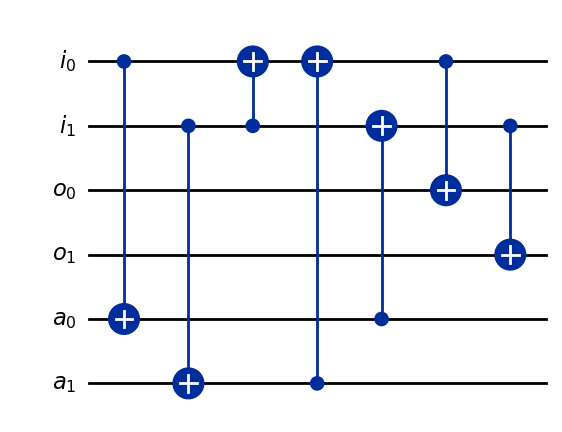

In [53]:
circ = small_example_circuit()


circ.draw('mpl')

['a0', 'a1']
['i0', 'i1']


Adding Nodes for Circuit: 100%|██████████| 7/7 [00:00<00:00, 56789.42it/s]

[CGNode: Labeled i0 @ index: 0 of type input is a initialize node.
, CGNode: Labeled i1 @ index: 1 of type input is a initialize node.
, CGNode: Labeled o0 @ index: 2 of type output is a initialize node.
, CGNode: Labeled o1 @ index: 3 of type output is a initialize node.
, CGNode: Labeled a0 @ index: 4 of type ancilla is a initialize node.
, CGNode: Labeled a1 @ index: 5 of type ancilla is a initialize node.
, CGNode: Labeled a0 @ index: 6 of type ancilla is a computation node.
, CGNode: Labeled a1 @ index: 7 of type ancilla is a computation node.
, CGNode: Labeled i0 @ index: 8 of type input is a computation node.
, CGNode: Labeled i0 @ index: 9 of type input is a computation node.
, CGNode: Labeled i1 @ index: 10 of type input is a computation node.
, CGNode: Labeled o0 @ index: 11 of type output is a computation node.
, CGNode: Labeled o1 @ index: 12 of type output is a computation node.
]


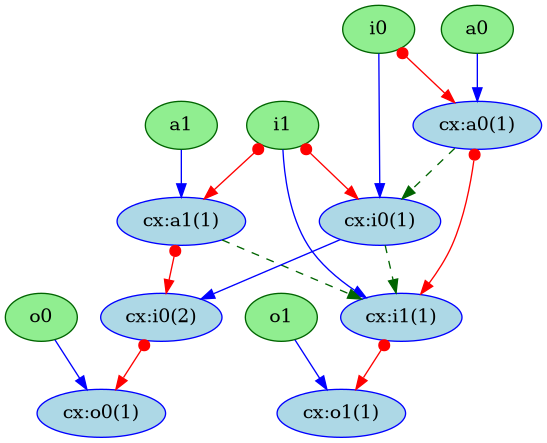

In [54]:
qubits =  [breakdown_qubit(q)['label'] for q in circ.qubits]

# ancillas_list = qubits[:num_i] + qubits[-num_a:] 
ancillas_list = qubits[-num_a:] 
inputs_list = qubits[:num_i]
outpus_list = qubits[num_i:num_i+num_o]


# output_list = qubits[num_i:num_i+num_o]
print(ancillas_list)
print(inputs_list)

# print(output_list)

cg = get_computation_graph(circ, ancillas_list, outputs=outpus_list)

print(cg.nodes())

graphviz_draw(cg,
                      node_attr_fn=node_attr,
                      edge_attr_fn=edge_attr)

[CGNode: Labeled i0 @ index: 0 of type input is a initialize node.
, CGNode: Labeled i1 @ index: 1 of type input is a initialize node.
, CGNode: Labeled o0 @ index: 2 of type output is a initialize node.
, CGNode: Labeled o1 @ index: 3 of type output is a initialize node.
, CGNode: Labeled a0 @ index: 4 of type ancilla is a initialize node.
, CGNode: Labeled a1 @ index: 5 of type ancilla is a initialize node.
, CGNode: Labeled a0 @ index: 6 of type ancilla is a computation node.
, CGNode: Labeled a1 @ index: 7 of type ancilla is a computation node.
, CGNode: Labeled i0 @ index: 8 of type input is a computation node.
, CGNode: Labeled i0 @ index: 9 of type input is a computation node.
, CGNode: Labeled i1 @ index: 10 of type input is a computation node.
, CGNode: Labeled o0 @ index: 11 of type output is a computation node.
, CGNode: Labeled o1 @ index: 12 of type output is a computation node.
, CGNode: Labeled i0 @ index: 13 of type input is a uncomputation node.
, CGNode: Labeled i1 @ 

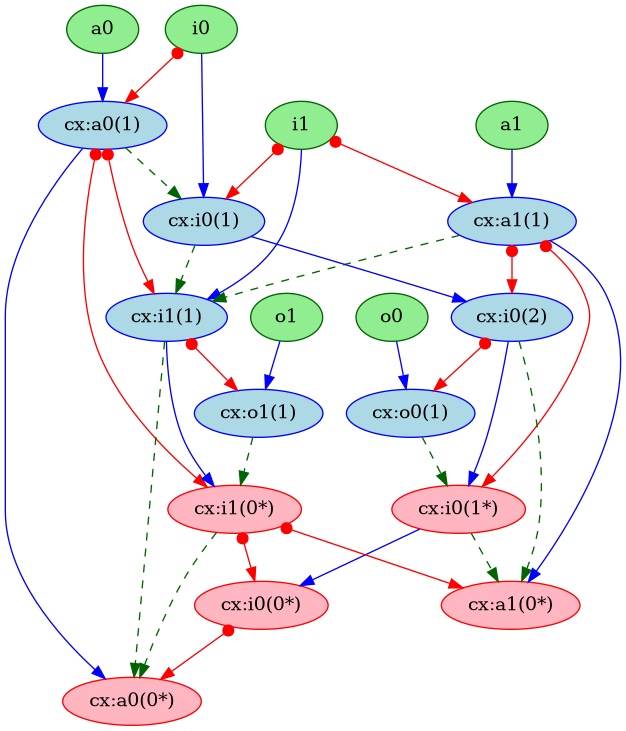

In [55]:
all_uncomp_cg = uncomp_operations(cg)
print(all_uncomp_cg.nodes())
graphviz_draw(all_uncomp_cg,
                      node_attr_fn=node_attr,
                      edge_attr_fn=edge_attr)

Building uncomp circuit from circuit graph: 100%|██████████| 18/18 [00:00<00:00, 84733.41it/s]

12


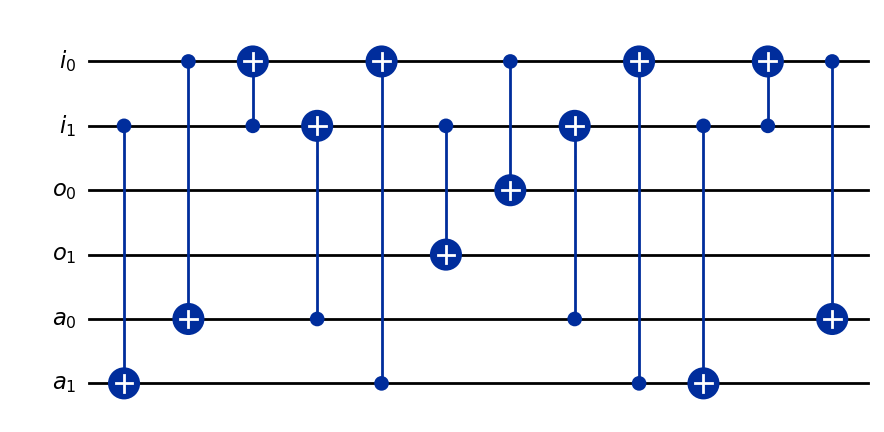

In [56]:
uncomp_circ = get_uncomp_circuit(all_uncomp_cg)
print(sum(uncomp_circ.count_ops().values()))
uncomp_circ.draw('mpl')

False
[CGNode: Labeled i0 @ index: 0 of type input is a initialize node.
, CGNode: Labeled i1 @ index: 1 of type input is a initialize node.
, CGNode: Labeled o0 @ index: 2 of type output is a initialize node.
, CGNode: Labeled o1 @ index: 3 of type output is a initialize node.
, CGNode: Labeled a0 @ index: 4 of type ancilla is a initialize node.
, CGNode: Labeled a1 @ index: 5 of type ancilla is a initialize node.
, CGNode: Labeled a0 @ index: 6 of type ancilla is a computation node.
, CGNode: Labeled a1 @ index: 7 of type ancilla is a computation node.
, CGNode: Labeled i0 @ index: 8 of type input is a computation node.
, CGNode: Labeled i0 @ index: 9 of type input is a computation node.
, CGNode: Labeled i1 @ index: 10 of type input is a computation node.
, CGNode: Labeled o0 @ index: 11 of type output is a computation node.
, CGNode: Labeled o1 @ index: 12 of type output is a computation node.
, CGNode: Labeled a0 @ index: 13 of type ancilla is a uncomputation node.
, CGNode: Label

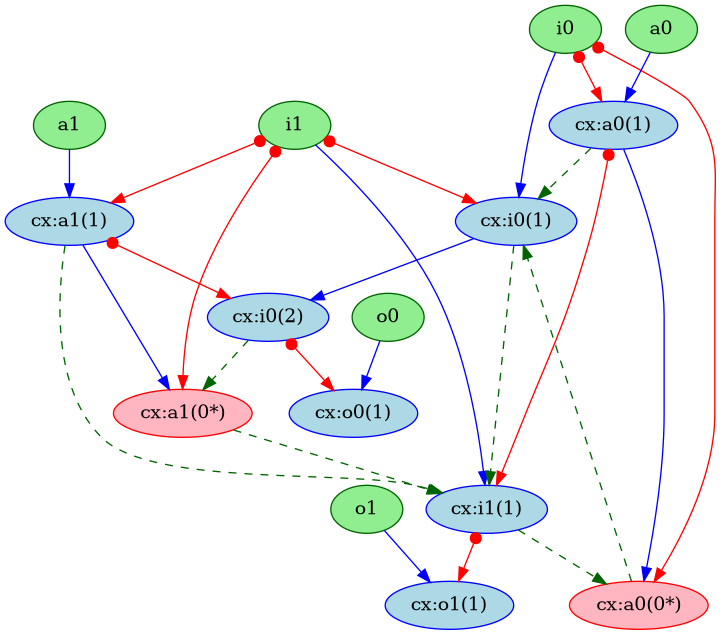

In [57]:
pldi_cyclic_uncomp_cg, has_cycles = add_uncomputation(cg, ancillas_list, allow_cycle=True)
print(has_cycles)
print(pldi_cyclic_uncomp_cg.nodes())
graphviz_draw(pldi_cyclic_uncomp_cg,
                      node_attr_fn=node_attr,
                      edge_attr_fn=edge_attr)


In [58]:
ANCILLA = StringConstants.ANCILLA.value


pldi_simple_cycles = simple_cycles(pldi_cyclic_uncomp_cg)
ancilla_counter = Counter(ancillas_list)
ancilla_counter.subtract(ancillas_list)
inputs_counter = Counter(inputs_list)
inputs_counter.subtract(inputs_list)

print(ancilla_counter)

for cycle in pldi_simple_cycles:
    print([pldi_cyclic_uncomp_cg.get_node_data(i).simple_graph_label() for i in cycle])
    for i in cycle:
        comp_node = pldi_cyclic_uncomp_cg.get_node_data(i)
        if comp_node.qubit_type is ANCILLA:
            ancilla_counter[f'{comp_node.qubit_name}{comp_node.qubit_wire}'] += 1
        if comp_node.qubit_type is INPUT:
            inputs_counter[f'{comp_node.qubit_name}{comp_node.qubit_wire}'] += 1

print(ancilla_counter)
print(inputs_counter)

Counter({'a0': 0, 'a1': 0})
['cx:a0(0*)', 'cx:i0(1)', 'cx:i0(2)', 'cx:a1(0*)', 'cx:i1(1)']
['cx:a0(0*)', 'cx:i0(1)', 'cx:i1(1)']
Counter({'a0': 2, 'a1': 1})
Counter({'i0': 3, 'i1': 2})


In [59]:
# def add_uncomp_input_node(node_index: int, circuit_graph:rustworkx.PyDiGraph):
#     '''
#     Algorithm for adding uncomp for an input qubit node/gate. 
#     1.  Get node 'c' to uncompute. Get node_num 'i' of this node. 
#     2.  If node has a target edge and uncomp node of qubit with node_num 'i' 
#         does not exist, then recursively uncompute node with node_num 'i'
#     3.  At this point, uncomp node of node_num 'i' should exist.
#     4.  Create new uncomp node 'c*' with node_num 'i-1' for the input qubit. 
#     5.  Restructing edges:
#         5.1 Any control edges to UNCOMP nodes from c will be redirected to c*
#         5.2 Anti dep edges from any UNCOMP node to node 'i' where node 'c' 
#             is the control can be removed
#     '''

#     comp_node = circuit_graph.get_node_data(node_index)
#     assert comp_node.node_type is COMP, f"Node is not {COMP} node." 
#     assert comp_node.qubit_type is INPUT, f"Node is not {INPUT} node."


#     node_num = comp_node.get_nodenum()
#     qubit = comp_node.label
#     print(node_num)

#     incoming_edges = circuit_graph.adj_direction(node_index, True)
#     outgoing_edges = circuit_graph.adj_direction(node_index, False)

#     print(incoming_edges)
#     print(outgoing_edges)

#     target = [x for x in outgoing_edges.items() if x is TARGET]
#     uncomped = [node for node in circuit_graph.nodes() \
#                 if node.label == qubit and node.get_nodenum == node_num and node.node_type is UNCOMP]
    
#     print(target)
#     print(uncomped)

#     if  len(target) and len(uncomped):

#         assert len(uncomped) == 1, f'Uncomped Node List has more than 1 node, this is wrong.'
#         to_be_uncomped = uncomped[0]

#         print(f'{comp_node.simple_graph_label()} can not be uncomputed yet, as the successive\
#               nodenum is yet to be uncomputed. \n \
#               Uncomputing {to_be_uncomped.simple_graph_label()}.')
        
#         add_uncomp_input_node(to_be_uncomped.get_index(), circuit_graph)
    
#     # At this point, either the input qubit node should have no target edge, 
#     # or uncomp node with node num 'i' exists. 

#     uncomp_node_idx, has_cycle = add_uncomputation_step(circuit_graph, node_index, return_uncomp_node=True)

#     if has_cycle:
#         print(f'CG has cycles')    
        

#     uncomp_node = circuit_graph.get_node_data(uncomp_node_idx)

#     print(uncomp_node)

#     ## TODO - Step 5
#     # 5.1 Any control edges to UNCOMP nodes from c will be redirected to c*
#     prev_node = [x for x,y in incoming_edges.items() \
#                                if y == TARGET]
#     print(prev_node)
#     assert len(prev_node) == 1
#     c_node = prev_node[0]
#     c_node_outgoing_edges = circuit_graph.adj_direction(c_node, False)

#     uncomp_nodes_controlled = [x for x,y in c_node_outgoing_edges.items() \
#                                if y == CONTROL and circuit_graph.get_node_data(x).node_type == UNCOMP]
    
#     print(uncomp_nodes_controlled)
#     for n in uncomp_nodes_controlled:
#         circuit_graph.remove_edge(c_node, n)
#         circuit_graph.add_edge(uncomp_node_idx, n, CONTROL)

    
#     # 5.2 Anti dep edges from any UNCOMP node to node 'i' where node 'c' is the control can be removed
#     old_anti_dep = [x for x,y in incoming_edges.items() \
#                                if y == ANTIDEP and circuit_graph.get_node_data(x).node_type == UNCOMP]
    
#     print(old_anti_dep)
#     for n in old_anti_dep:
#         circuit_graph.remove_edge(n,node_index)



#     return circuit_graph


In [60]:
# def reverse_input_qubits(circuit_graph:rustworkx.PyDiGraph):

#     '''
#     Algorithm for greedily adding uncomp for input qubits nodes in a 
#     cyclic uncomp cg 
#     '''

#     input_init_nodes = [node for node in circuit_graph.nodes() if node.node_type == INIT and node.qubit_type is INPUT]
#     input_qubits = [node.label for node in input_init_nodes]
#     input_qubits_counter = collections.Counter(input_qubits)
#     input_qubits_counter.subtract(input_qubits)
#     input_target_nodes = {}
#     for node in input_init_nodes:
#         qubit = node.label
#         targets = []
#         target_node = circuit_graph.find_adjacent_node_by_edge(node.get_index(), lambda x : x == TARGET)

#         while target_node:
#             targets.append(target_node)
#             try:
#                 target_node = circuit_graph.find_adjacent_node_by_edge(target_node.get_index(), lambda x : x == TARGET)
#             except:
#                 target_node = None

#         input_target_nodes.update({qubit:targets})

#     print(input_target_nodes)

#     pass

# def greedy_metric_num_uncomp_antidep(node_index:int, circuit_graph:rustworkx.PyDiGraph):
#     '''
#     The greedy metric here is most number of anti dependency edges from ancilla uncomp nodes 
#     that come into the node.
#     '''
#     return len([x for x,y in circuit_graph.adj_direction(node_index, True).items() 
#                         if y is ANTIDEP and circuit_graph.get_node_data(x).qubit_type is ANCILLA 
#                         and circuit_graph.get_node_data(x).node_type is UNCOMP])

# def greedily_select_input_node(circuit_graph:rustworkx.PyDiGraph):
#     '''
#     This method determines the best input qubit to uncompute by choosing the input qubit
#     with the specified greedy metric. 
#     '''
#     best_index = 0
#     for idx in circuit_graph.node_indices():
#         node = circuit_graph.get_node_data(idx)
#         best_node = circuit_graph.get_node_data(best_index)

#         if  node.qubit_type is INPUT and node.node_type is COMP \
#             and greedy_metric_num_uncomp_antidep(idx, circuit_graph) > greedy_metric_num_uncomp_antidep(best_index, circuit_graph) :
            
#             best_index = idx

#     return best_index

# def uncompute_input_nodes_greedy(circuit_graph:rustworkx.PyDiGraph):
#     while rustworkx.digraph_find_cycle(circuit_graph):
#         best_node_to_uncompute = greedily_select_input_node(circuit_graph)
#         print(f'Best Node to uncompute is {best_node_to_uncompute} : {circuit_graph.get_node_data(best_node_to_uncompute).simple_graph_label()}')
#         add_uncomp_input_node(best_node_to_uncompute, circuit_graph)
    
#     return circuit_graph



In [61]:

pldi_cyclic_uncomp_cg_i0 = add_uncomp_input_node(8, copy.deepcopy(pldi_cyclic_uncomp_cg))

cx:i0(1) can not be uncomputed yet, as the successive nodenum is yet to be uncomputed.
              Uncomputing cx:i0(2).
Now uncomputing 9:cx:i0(2)
Added Uncomp for cx:i0(2) but CG has cycles
Now uncomputing 8:cx:i0(1)
Cycles from CG removed when added uncomp for cx:i0(1)!


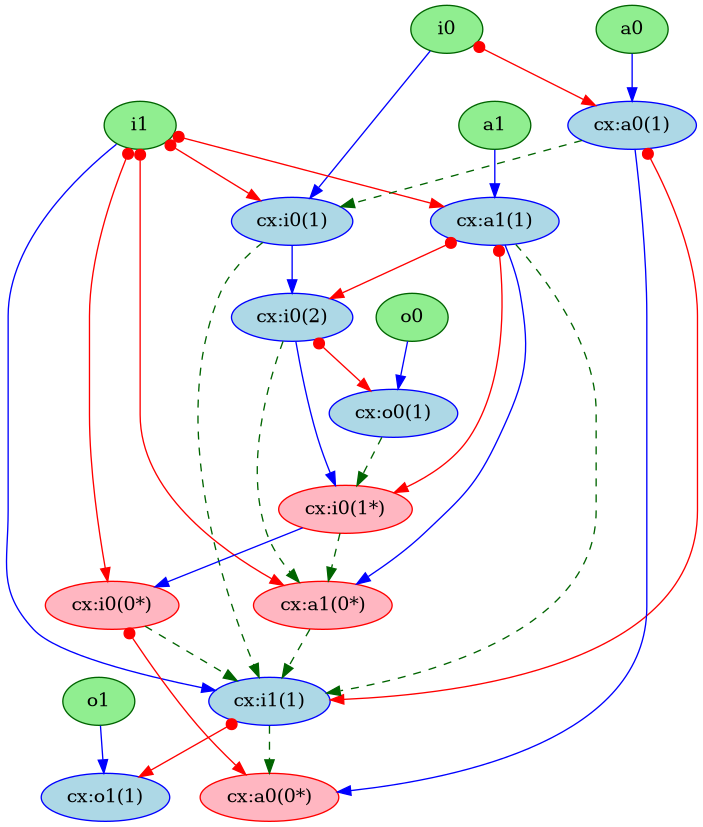

In [62]:
graphviz_draw(pldi_cyclic_uncomp_cg_i0,
                      node_attr_fn=node_attr,
                      edge_attr_fn=edge_attr)

Building uncomp circuit from circuit graph: 100%|██████████| 17/17 [00:00<00:00, 69905.07it/s]


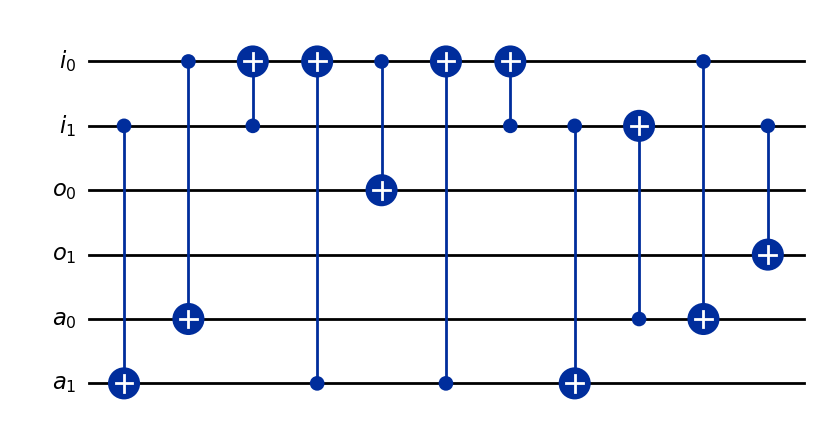

In [63]:
uncomp_i0_circ = get_uncomp_circuit(pldi_cyclic_uncomp_cg_i0)

uncomp_i0_circ.draw('mpl')

In [64]:
pldi_cyclic_uncomp_cg_i1 = add_uncomp_input_node(10, copy.deepcopy(pldi_cyclic_uncomp_cg))

Now uncomputing 10:cx:i1(1)
Added Uncomp for cx:i1(1) but CG has cycles


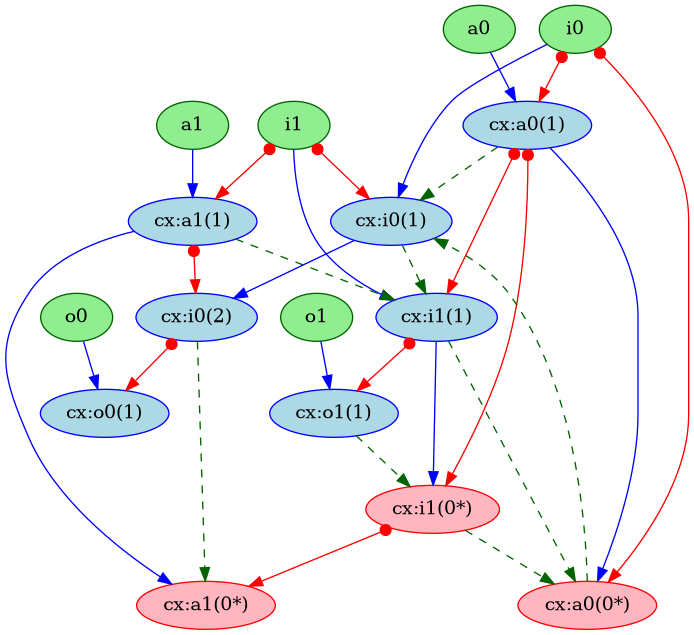

In [65]:
graphviz_draw(pldi_cyclic_uncomp_cg_i1,
                      node_attr_fn=node_attr,
                      edge_attr_fn=edge_attr)

In [66]:
greedy_input_uncomp_cg = uncompute_input_nodes_greedy(copy.deepcopy(pldi_cyclic_uncomp_cg))

Best Node to uncompute is 8 : cx:i0(1)
cx:i0(1) can not be uncomputed yet, as the successive nodenum is yet to be uncomputed.
              Uncomputing cx:i0(2).
Now uncomputing 9:cx:i0(2)
Added Uncomp for cx:i0(2) but CG has cycles
Now uncomputing 8:cx:i0(1)
Cycles from CG removed when added uncomp for cx:i0(1)!


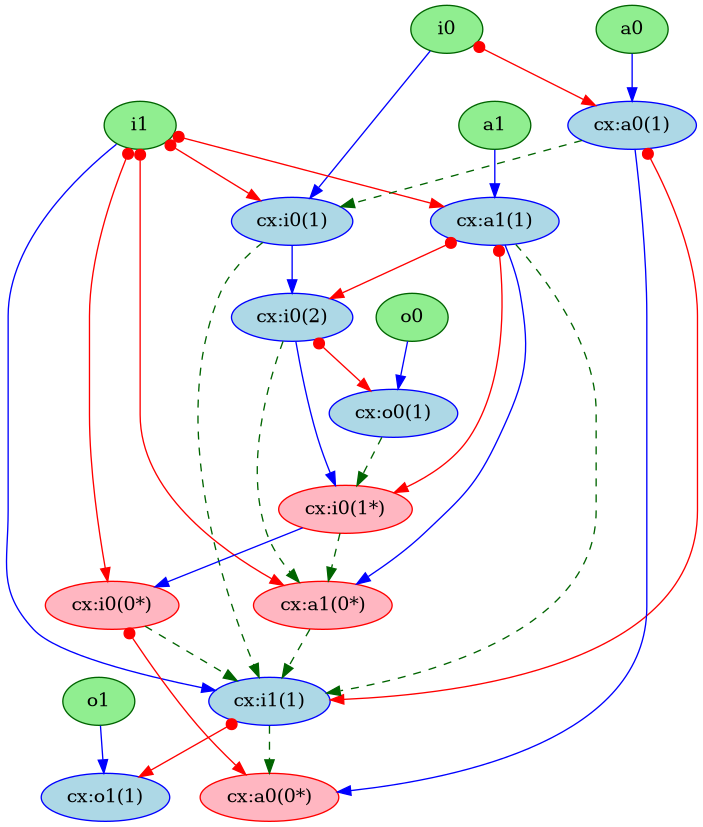

In [67]:
graphviz_draw(greedy_input_uncomp_cg,
                      node_attr_fn=node_attr,
                      edge_attr_fn=edge_attr)

Building uncomp circuit from circuit graph: 100%|██████████| 17/17 [00:00<00:00, 52428.80it/s]


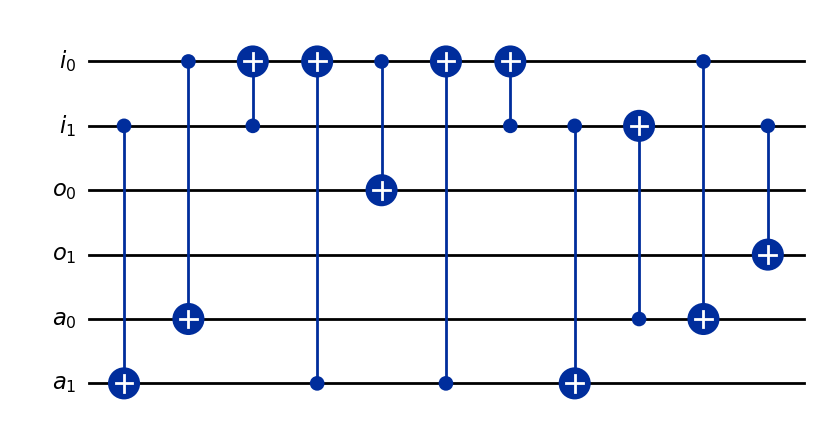

In [68]:
uncomp_input_circ = get_uncomp_circuit(greedy_input_uncomp_cg)

uncomp_input_circ.draw('mpl')

In [69]:
circ_num_op = sum(circ.count_ops().values())
bennetts_num_op = sum(uncomp_circ.count_ops().values())
greedy_uncomp_input_op = sum(uncomp_input_circ.count_ops().values())

print(circ_num_op, bennetts_num_op, greedy_uncomp_input_op)

7 12 11


In [70]:
circ_num_op = sum(circ.decompose(reps=10).count_ops().values())
bennetts_num_op = sum(uncomp_circ.decompose(reps=10).count_ops().values())
greedy_uncomp_input_op = sum(uncomp_input_circ.decompose(reps=10).count_ops().values())

print(circ_num_op, bennetts_num_op, greedy_uncomp_input_op)

7 12 11
